# Определение успешных игр для интернет-магазина

Для интернет-магазина , который продаёт по всему миру компьютерные игры нужно провести анализ на основе открытых источников исторических данных о продажах игр, оценках пользователей и экспертов, жанрах и платформах (например, Xbox или PlayStation). 

**Цель**: выявить закономерности успешности разных игр, платформ, жанров в разных регионах. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными.

## Изучение и предобработка данных

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
#Проверим, есть ли дубликаты. 
games[games.duplicated(keep = False)] # keep = False выведет все совпадения
#таблица пустая - дубликатов нет

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating


In [6]:
games.columns = games.columns.str.lower() #приведем к нижнему регистру названия столбцов

In [7]:
#заменим tbd(to be determined) на Nan, для изменения на тип данных float
games.loc[games['user_score'] == 'tbd', 'user_score'] = float('nan')
games['user_score'] = games['user_score'].astype(float)
games['user_score'].dtype #проверка

dtype('float64')

В Year_of_Release пропусков немного, менее 1%, поэтому их удалим. Также удалим строки с пропусками в Name и Genre, их всего 2. 

In [8]:
round(len(games['year_of_release'].value_counts())/len(games['platform'])*100,2)

0.22

In [9]:
games.dropna(subset=['year_of_release'], inplace=True) # удаляем строки с пропусками в year_of_release
games['year_of_release'] = games['year_of_release'].astype(int)#изменяем тип данных на целочисленный
games['year_of_release'].dtype

dtype('int64')

In [10]:
games.dropna(subset=['name'], inplace=True)

In [11]:
#посчитаем суммарные продажи
games['sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [12]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
sales              16444 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


**Вывод**

Мы удалили строки с пропусками в ключевых столбцах, так как их менее 1%. Эти пропуски не заменяли, так это могло бы повлиять на результаты исследования. Заменили, где необходимо, тип данных и вывели столбец с продажами (млн. копий) по всем регионам в сумме. Данные готовы для исследовательского анализа. 

## Исследовательский анализ данных

### Динамика продаж игр за весь период 

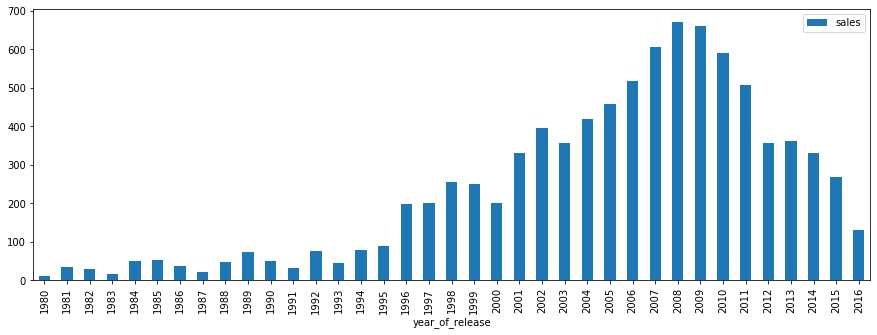

In [13]:
#посмотрим, сколько игра выпускалось в разные годы
(
    games.groupby('year_of_release').agg({'sales': 'sum'})
    .sort_values(by='year_of_release').plot(kind='bar', figsize =(15,5))
)

Больше всего игр выпускалось в 2008 и в 2009 годы. За 2016 год видимо данные не полные, поэтому наблюдаем такое резкое падение. В период 1980 - 1995 объемы продаж (милн копий) очень невысоки, их можно не принимать в расчет.

### Платформы

Посмотрим, как менялись продажи по платформам. Выберим платформы с наибольшими суммарными продажами и построим распределение по годам.

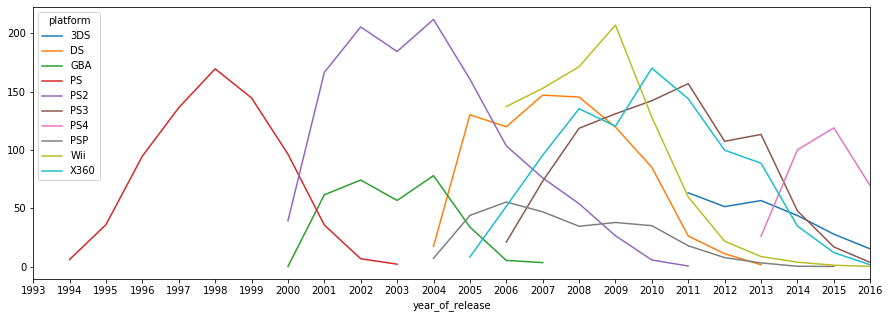

In [14]:
#выберем топ-10 платформ по суммарным продажам
top_ten = games.groupby('platform').agg({'sales':'sum'}).sort_values(by='sales').tail(10).index
# построим распределение по годам для топ-10 платформ
(
    games.query('platform in @top_ten')
    .pivot_table(index='year_of_release', columns='platform', values='sales', aggfunc='sum')
    .plot(figsize=(15,5), xlim=(1993, 2016), xticks=(games['year_of_release'].unique()))
)    

За исследуемый период 1994 - 2016 мы видим платформы несоколько раз появлялись и исчезали. Нужно посчитать средний срок жизни платоформ (актуальный период), чтобы спрогнозировать динамику продаж после 2016 года.

### Актуальный период

In [15]:
# посчитаем актуальный период для топ-10 платформ
# возьмем для этого игры с суммарными продажами более 1 млн копий
actual_period = games.groupby(['platform','year_of_release']).agg({'sales': 'sum'}).query('platform in @ top_ten and sales > 1')
# расчитает жизненный период каждой платформы
actual_period = actual_period.reset_index().groupby('platform').agg({'year_of_release': 'count'}) 

print(actual_period)
print()
print('Средний срок жизни платформы')
actual_period.mean() # расчитает сколько в среднем живет платформа

          year_of_release
platform                 
3DS                     6
DS                     10
GBA                     7
PS                     10
PS2                    11
PS3                    11
PS4                     4
PSP                    10
Wii                    10
X360                   12

Средний срок жизни платформы


year_of_release   9.10
dtype: float64

Платформы в среднем живут 9 лет. До середины этого периода продажи растут, потом достигнув пика падают. Для выявления потенциально прибыльных платформ возьмем период после 2011 года, чтобы захватить платформы, находящиеся в первой половине среднего срока жизни. Это и будет **актуальный период**.

### Потенциально прибыльные платформы

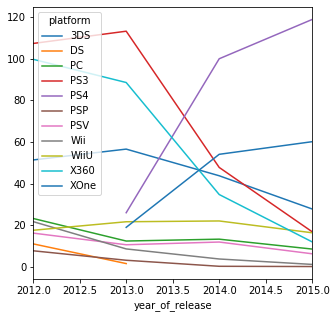

In [16]:
#выбираем потенциально прибыльные платформы
games_new = games.query('2011 < year_of_release < 2016') #актуальный период
games_new_top = games_new.groupby('platform').agg({'sales':'sum'}).sort_values(by='sales').tail(10).index
games_new.pivot_table(index='year_of_release', columns='platform', values='sales', aggfunc='sum').plot(figsize=(5,5))
plt.show()
new_platforms=['PS4', 'XOne', '3DS', 'PC']

Для определения потенциально прибыльных платформ не будем принимать во внимание 2016 г, тк данные неполные. В период до 2015 г включительно только у двух платформ наблюдается рост продаж - это **PS4** и **XOne**. Еще у двух платформ **3DS** и **PC** стабильный и сравнительно высокий уровень продаж. У остальных платформ продажи значительно ниже и/или продолжают резкое снижение на момент 2015 г.

### Ящик с усами для перпспективных платформ

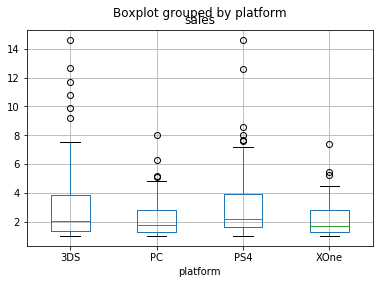

In [17]:
#ящик с усами для перспективных платформ
games.query('platform in @ new_platforms and sales > 1').boxplot(column = 'sales', by = 'platform')
plt.show()

Все 4 выбранные платформы в целом схожи по показателям. Медианные продажи около 2 миллионов копий. Самые высокие у PS4. Есть и небольшие различия. Самые низкие волатильность продаж и стандартное отклонение у PC, что было видно из предыдущего графика - у этой платформы стабильный и невысокий уровень продаж за весь период. У 3DS и PS4 много выбросов больших значений - есть отдельные игры-бестселлеры.

### Влияние отзывов

Чтобы понять как отзывы влияют на продажи, построим для четырех выбранных платформ диаграммы рассеяния и посчитаем коэффициент корреляции.

PS4 : коэффициент корреляции


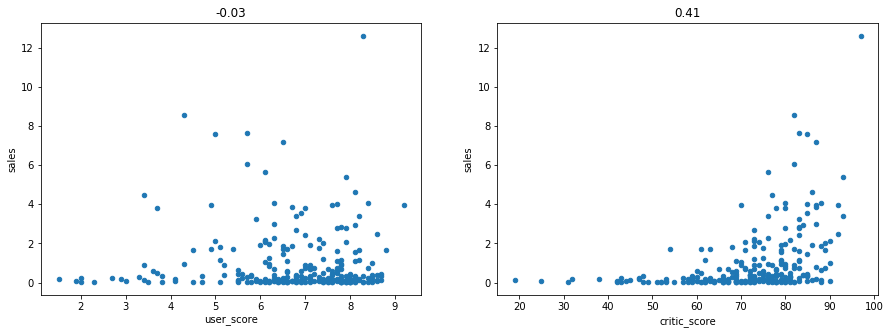

XOne : коэффициент корреляции


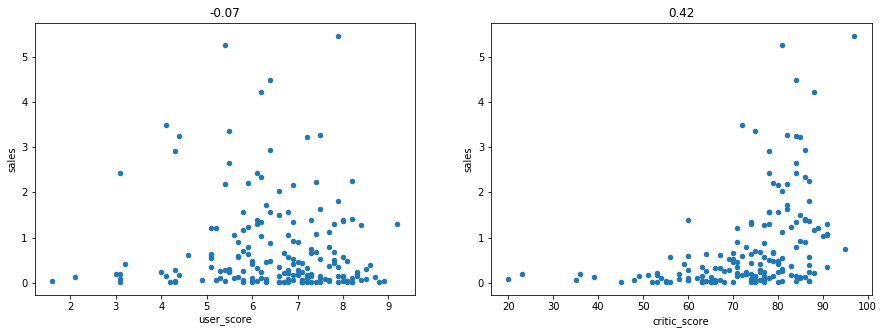

3DS : коэффициент корреляции


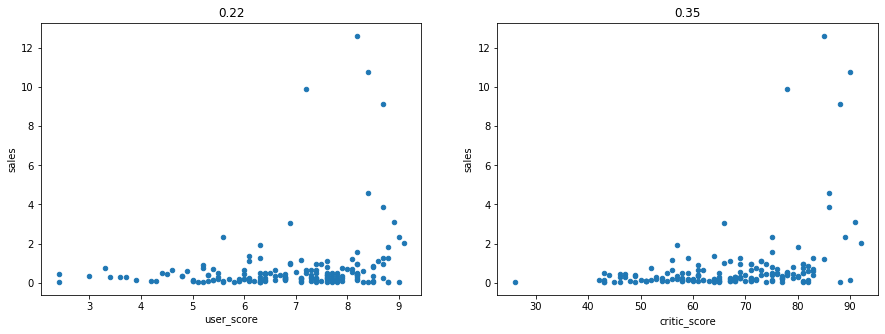

PC : коэффициент корреляции


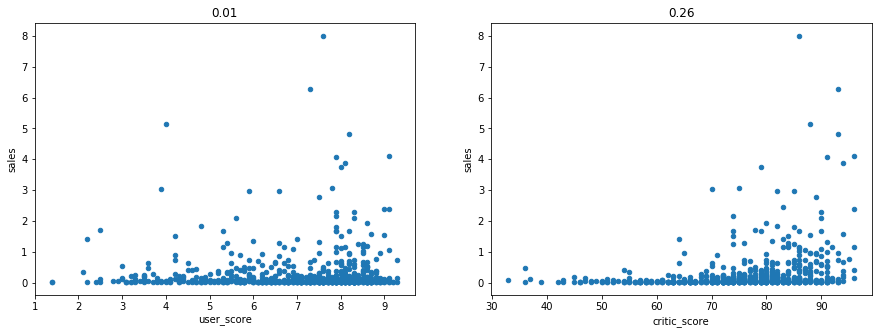

In [18]:
scores=['user_score', 'critic_score']
for platform in new_platforms:
    print(platform, ': коэффициент корреляции')
    games_plat=games.query('platform==@platform')
    plt.subplots(figsize = (15,5)) #сетка графиков
    for plot_num, score in enumerate (scores):
        games_plat.plot(ax=plt.subplot(1, len(scores), plot_num+1), x=score, y='sales', kind='scatter', title=(round(games_plat['sales'].corr(games_plat[score]),2)))
    plt.show()
   

**Вывод.**
Отзывы пользователей почти не влияют на размеры продаж. Коэффициент корреляции близок к нулю, а в некоторых случаях, даже отрицательный. Между отзывами критиков и продажами более сильная зависимость. Коэффициент корреляции изменяется от 0.26 у PC (в принципе очень стабильная платформы) и 0.42 у XOne. Зависимость тоже не сильная. 

### Жанры

Посмотрим распределения игр по жанрам.

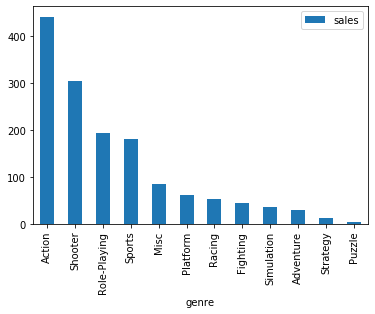

In [19]:
games.query('year_of_release>2011').groupby('genre').agg({'sales':'sum'}).sort_values(by='sales', ascending=False).plot(kind='bar', y='sales', legend=True)
plt.show()

Самый популярный жанр - Action, так же в лидеры входят Shooter, Role-Playing и Sports.

Наименее популярные жанры - Strategy, Adventure, Simulation и Puzzle

### Портрет пользователя каждого региона

#### Топ-5 платформ для каждого региона

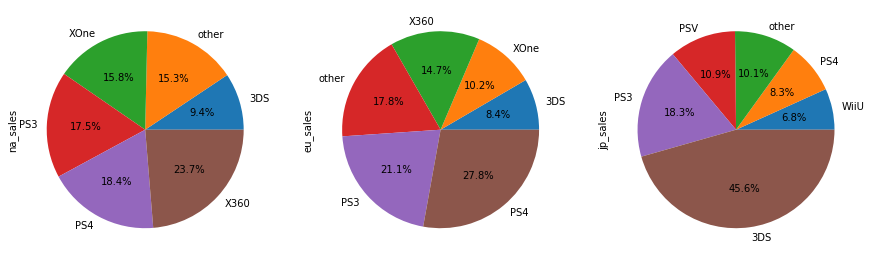

In [20]:
plt.subplots(figsize = (15,5)) #сетка графиков
regions =['na_sales', 'eu_sales', 'jp_sales']
for plot_num, region in enumerate(regions):
    reg_plat = games.query('year_of_release>2011').groupby('platform').agg({region : 'sum'}).sort_values(by=region, ascending=False)
    reg_top_plat=reg_plat.head()
    reg_plat = reg_plat.reset_index()
    reg_plat['platform'] = reg_plat['platform'].where(reg_plat['platform'].isin(reg_top_plat.index), 'other')
    reg_plat.groupby('platform').agg({region : 'sum'}).sort_values(by=region).plot(kind='pie', 
                                                            # определение ячейки сетки
                                                            ax = plt.subplot(1,           #число рядов, 
                                                                            len(regions), #число столбцов
                                                                            plot_num + 1),#порядковый номер графика
                                                            y=region, autopct='%1.1f%%', legend=False)


**Вывод**

NA и EU очень похожи. JP отличается от них. Топ-5 у них одинаковый, с различиями только в долях. В NA более популярна X360, а в EU PS4.

В JP очень популярна 3DS. Также есть две популярные платформы WiiU и PSV, которые не распространены в других регионах. 



#### Топ-5 жанров

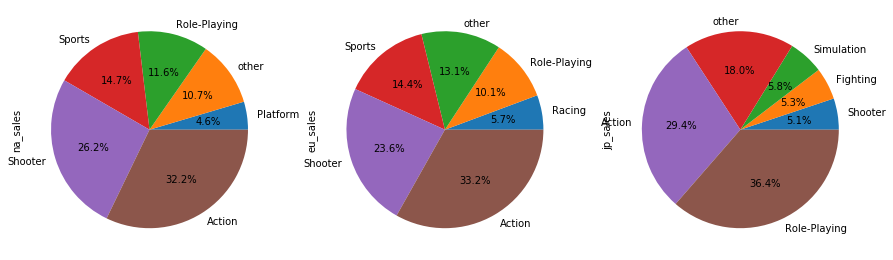

In [21]:
plt.subplots(figsize = (15,5)) #сетка графиков
regions =['na_sales', 'eu_sales', 'jp_sales']
for plot_num, region in enumerate(regions):
    reg_plat = games.query('year_of_release>2011 and genre!="Misc"').groupby('genre').agg({region : 'sum'}).sort_values(by=region, ascending=False)
    reg_top_plat=reg_plat.head()
    reg_plat = reg_plat.reset_index()
    reg_plat['genre'] = reg_plat['genre'].where(reg_plat['genre'].isin(reg_top_plat.index), 'other')
    reg_plat.groupby('genre').agg({region : 'sum'}).sort_values(by=region).plot(kind='pie',
                                                         # определение ячейки сетки
                                                          ax = plt.subplot(1,           #число рядов, 
                                                                            len(regions), #число столбцов
                                                                            plot_num + 1),#порядковый номер графика
                                                         y=region, legend=False, autopct='%1.1f%%')


**Вывод**

NA и EU очень похожи.  В топ-5 различие только в одной позиции. В NA более популярен Platform, а в EU Racing. JP отличается от них.

В JP очень популярен Role-Playing. Также есть две популярные платформы Simulation и Fighting, которые не распространены в других регионах. 

#### ESPRB рейтинг

In [22]:
#избавимся от пропусков, заполнив их NA (not avaliable), чтобы определить зависимость
games['rating'] = games['rating'].fillna('NA') 

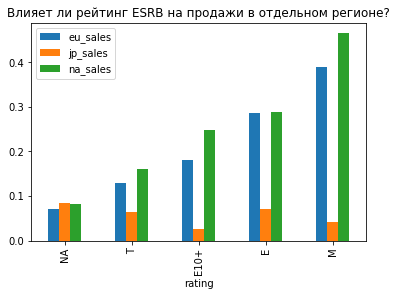

In [23]:
(games
     .query('year_of_release>2011')
     .pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'])
     .sort_values('na_sales')
     .plot(kind='bar', title='Влияет ли рейтинг ESRB на продажи в отдельном регионе?')
     )
plt.show()

Наиболее популярны игры с рейтингом Mature и  Everyone. Everyone 10 and older и Teen менее популярны. ESRB - это американский рейтинг, он менее распространен в Японии, график это подтверждает. 

**Портреты пользователей**

**NA**

Предпочитает играть на платформах X360, PS4, PS3, XOne. Больше всего любит жанры Action и Shooter и игры для взослой аудитории.

**EU**

Из платформ предпочитает PlayStation (PS3 и PS4). Больше всего любит жанры Action и Shooter и игры для взослой аудитории.

**JP**

Наиболее популярна платформа 3DS, жанры - Role-Playing и Action. Американский ESPRB рейтинг не популярен.


## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

**Нулевая гипотеза**: Средние пользовательские рейтинги платформ Xbox One и PC равны. 
Если p-value будет ниже уровня значимости alfa 5%, то мы ее отвергнем и можно будет принять **альтернативную гипотезу**, что эти средние не равны.

In [24]:
sample_XOne = games[(~games['user_score'].isna()) & (games['platform'] == 'XOne')]['user_score']
sample_PC = games[(~games['user_score'].isna()) & (games['platform'] == 'PC')]['user_score']
alpha=0.05
results=st.ttest_ind(sample_XOne, sample_PC)
print('p-value:', results.pvalue)
if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергнуть нулевую гипотезу')


p-value: 1.3037979620149106e-05
Отвергаем нулевую гипотезу


In [25]:
XOne_mean = round(games[(~games['user_score'].isna()) & (games['platform'] == 'XOne')]['user_score'].mean(), 1)
PC_mean = round(games[(~games['user_score'].isna()) & (games['platform'] == 'PC')]['user_score'].mean(), 1)
print('Для справки, средние показатели:')
print(XOne_mean, PC_mean)

Для справки, средние показатели:
6.5 7.1


### Средние пользовательские рейтинги жанров Action и Sports разные.

**Нулевая гипотеза**: Средние пользовательские рейтинги жанров Action и Sports  равны. 
Если p-value будет ниже уровня значимости alfa 5%, то мы ее отвергнем и можно будет принять **альтернативную гипотезу**, что эти средние разные.

In [26]:
sample_Action = games[(~games['user_score'].isna()) & (games['genre'] == 'Action') & (games['year_of_release']>2011)]['user_score']
sample_Sports = games[(~games['user_score'].isna()) & (games['genre'] == 'Sports') & (games['year_of_release']>2011)]['user_score']
alpha=0.05
results=st.ttest_ind(sample_Action, sample_Sports)
print('p-value:', results.pvalue)
if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


In [27]:
Action_mean = round(games[(~games['user_score'].isna()) & (games['genre'] == 'Action') & (games['year_of_release']>2011)]['user_score'].mean(), 1)
Sports_mean = round(games[(~games['user_score'].isna()) & (games['genre'] == 'Sports') & (games['year_of_release']>2011)]['user_score'].mean(), 1)
print('Для справки, средние показатели:')
print(Action_mean, Sports_mean)

Для справки, средние показатели:
6.8 5.5


### Выводы:

Гипотезы о равенстве средних пользовательских рейтингах не подтвердились. 

## Общий вывод:

Для анализа на конец 2016 года был выбран следующий подход:
* актуальный период - начиная с 2012 (тенденции этого периода будут актуальны для периода с 2016 года)
* выбраны 4 платформы лидера ('PS4', 'XOne', '3DS', 'PC'), которые останутся прибыльными и в ближайшие годы (также определен средний срок жизни платформы - 9 лет)
* для потенциально прибыльных платформ проанализировано влияние отзывов пользователей и критиков на продажи. Отзыва пользователей почти не влияют продажи. Отзыва критиков оказывают влияние на продажи, но не сильное
* Из жанров самые популярные - это Action, Shooter, Role-Playing и Sports
* Для актуального периода были определены портреты пользователей из трех основных регионов: NA, EU, JP: какие платформы, жанры они предпочитают. Выяснилось, что NА и EU схожи между собой. А JP отличается от них. Это нужно учитывать при планировании региональных рекламных компании. 


Были проверены статистические гипотезы о равенстве средних пользоватетьских рейтингов у двух жанров и платформ. 